# Basic Stats

In [1]:
library(tools)
library(lattice)
library(repr)
library(stats)
library(fitdistrplus) # for exploratory distribution fitting
library(mixtools) # for fitting mixtures of distributions
library(pgirmess) # for kruskal-wallis multiple comparisons test

Loading required package: MASS
Loading required package: boot

Attaching package: ‘boot’

The following object is masked from ‘package:lattice’:

    melanoma

Loading required package: segmented
mixtools package, version 1.0.3, Released 2015-04-18
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.



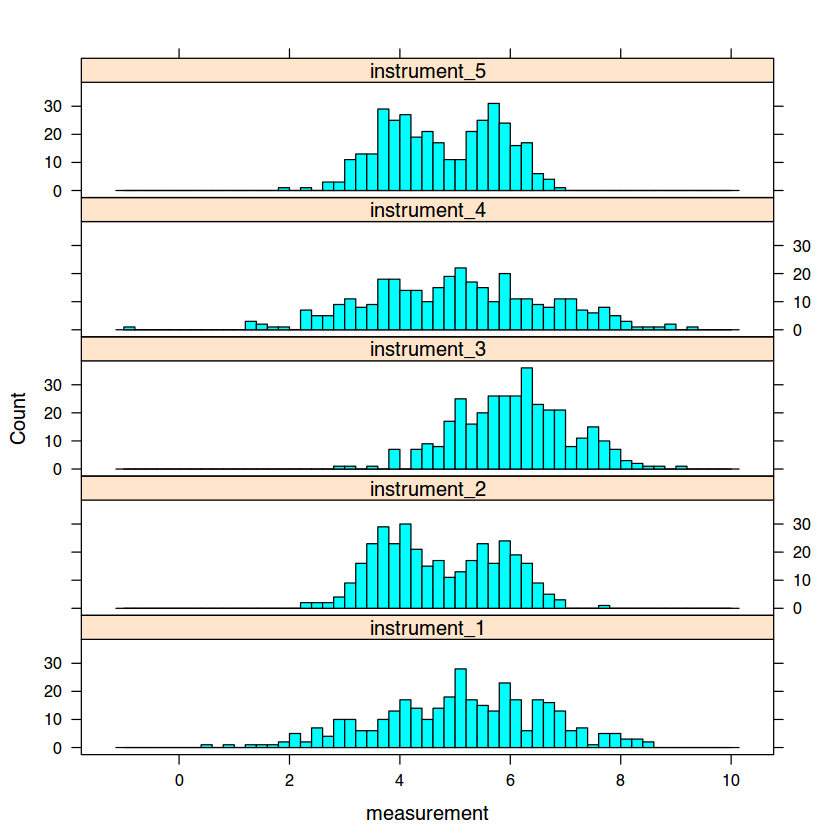

In [2]:
setwd('./data/')
instr_files <- c("instrument_1.txt","instrument_2.txt","instrument_3.txt","instrument_4.txt","instrument_5.txt")
instr_names <- lapply(instr_files,file_path_sans_ext)

dataset = data.frame(instrument=character(),measurement=numeric())
for (file in instr_files){
    measurement <- scan(file,sep=',',what=numeric(),dec = ".")
    instrument <- rep(file_path_sans_ext(file),length(measurement))
    # cbind() coerces numeric to factor... bad!
    temp3 <- cbind.data.frame(instrument,measurement)
    dataset <- rbind.data.frame(dataset,temp3)
    }
#head(dataset); tail(dataset)
histogram(~measurement|instrument,data=dataset,
          layout=c(1,5),
          type="count",
          breaks=seq(-1,10,by=0.2),
          aspect="fill")

## Which if any of these distributions would you consider normal? How did you come to those conclusions?

In [3]:
sw_pvalues <- tapply(dataset$measurement,dataset$instrument,function(...){shapiro.test(...)$p.value})
swtests <- tapply(dataset$measurement,dataset$instrument,function(...){shapiro.test(...)})
sw_pvalues

instrument_1 instrument_2 instrument_3 instrument_4 instrument_5 
9.091661e-02 6.092536e-07 6.928390e-01 3.571500e-01 2.053914e-07

#### Shown above are Shapiro-Wilk normality test p-values for each instrument's measurements ($H_0:$ data is normally distributed). With $\alpha=0.05$, instruments 2 and 5 don't generate normally distributed data, while instruments 3, 4, and 1 may generate normally distributed data.

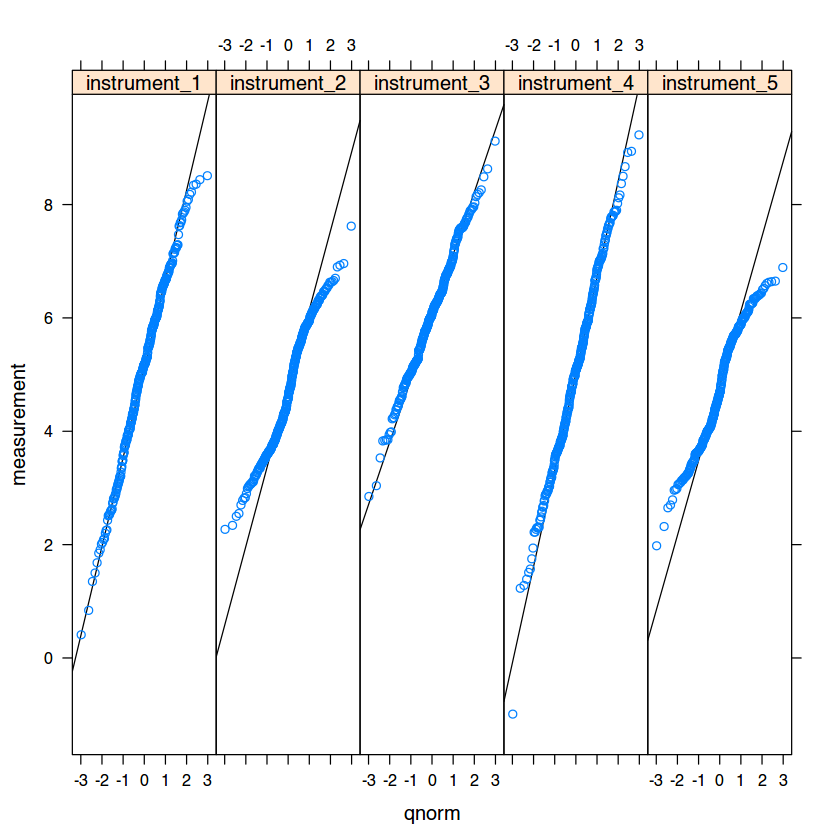

In [4]:
qqmath(~measurement|instrument,data=dataset,
       layout=c(5,1),
       aspect="fill",
       distribution=qnorm,
       prepanel = prepanel.qqmathline,
       panel = function(x, ...) {
          panel.qqmathline(x, ...)
          panel.qqmath(x, ...)
       })

#### Shown above are quartile-quartile plots of each instruments' empirical CDF (blue circles) vs normal distribution CDF (black line). These suggest that instruments 2 and 5 don't generate normally distributed data and are probably bimodal. While instruments 1, 3, and 4 appear to generate normally distributed data, the distribution of instrument 1's data might be a little heavy-tailed in comparison to a normal distribution.

## Which instrument(s) is/are most likely to return the expected response? 

In [5]:
tapply(dataset$measurement,dataset$instrument,summary)

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0


$instrument_1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.410   4.048   5.175   5.117   6.167   8.510 

$instrument_2
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.270   3.812   4.585   4.726   5.690   7.620 

$instrument_3
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.850   5.270   6.085   6.065   6.758   9.120 

$instrument_4
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.990   3.865   5.080   5.057   6.158   9.230 

$instrument_5
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.980   3.910   4.690   4.765   5.690   6.890 


#### Instrument 4 is most likely to return the expected response; its median (5.080) and mean (5.057) are closest to the target value (5).

## Which instrument(s) is/are the most reproducible?

In [6]:
tapply(dataset$measurement,dataset$instrument,var)

instrument_1 instrument_2 instrument_3 instrument_4 instrument_5 
    2.309200     1.186424     1.051832     2.589266     1.059751

#### Shown above are sample variances of each instruments' measurements. These suggest that instruments 3 and 5 are the most reproducible.

### Do the instruments generate statistically similar readings?

In [7]:
kruskalmc(measurement~instrument,data=dataset,
          alpha=0.05)
pairwise.wilcox.test(dataset$measurement,dataset$instrument,
                     p.adj="holm",
                     paired=FALSE,
                    alpha=0.05)

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[3]]) result is length 0


,obs.dif,critical.dif,difference
instrument_1-instrument_2,165.3257,107.226,TRUE
instrument_1-instrument_3,348.1714,107.226,TRUE
instrument_1-instrument_4,34.66857,107.226,FALSE
instrument_1-instrument_5,150.5986,107.226,TRUE
instrument_2-instrument_3,513.4971,107.226,TRUE
instrument_2-instrument_4,130.6571,107.226,TRUE
instrument_2-instrument_5,14.72714,107.226,FALSE
instrument_3-instrument_4,382.84,107.226,TRUE
instrument_3-instrument_5,498.77,107.226,TRUE
instrument_4-instrument_5,115.93,107.226,TRUE



	Pairwise comparisons using Wilcoxon rank sum test 

data:  dataset$measurement and dataset$instrument 

             instrument_1 instrument_2 instrument_3 instrument_4
instrument_2 0.00024      -            -            -           
instrument_3 < 2e-16      < 2e-16      -            -           
instrument_4 0.86159      0.01363      < 2e-16      -           
instrument_5 0.00087      0.86159      < 2e-16      0.03984     

P value adjustment method: holm 

#### A Wilcoxon–Mann–Whitney test with Bonferroni-Holm correction for multiple comparisons (p values shown above, $\alpha=0.05$) suggests that instruments 1 and 4, and instruments 2 and 5, generate measurements that come from the same distribution (e.g., which are statistically similar). As a group, the instruments are not statistically similar to one another. A Kruskal-Wallis multiple comparisons test also suggests the same similarities and differences.

## Estimate the type(s) and parameter values of all five distributions.

Fitting of the distribution ' norm ' by maximum likelihood 
Parameters : 
     estimate Std. Error
mean 5.116914 0.08111020
sd   1.517433 0.05735346
Loglikelihood:  -642.5855   AIC:  1289.171   BIC:  1296.887 
Correlation matrix:
     mean sd
mean    1  0
sd      0  1


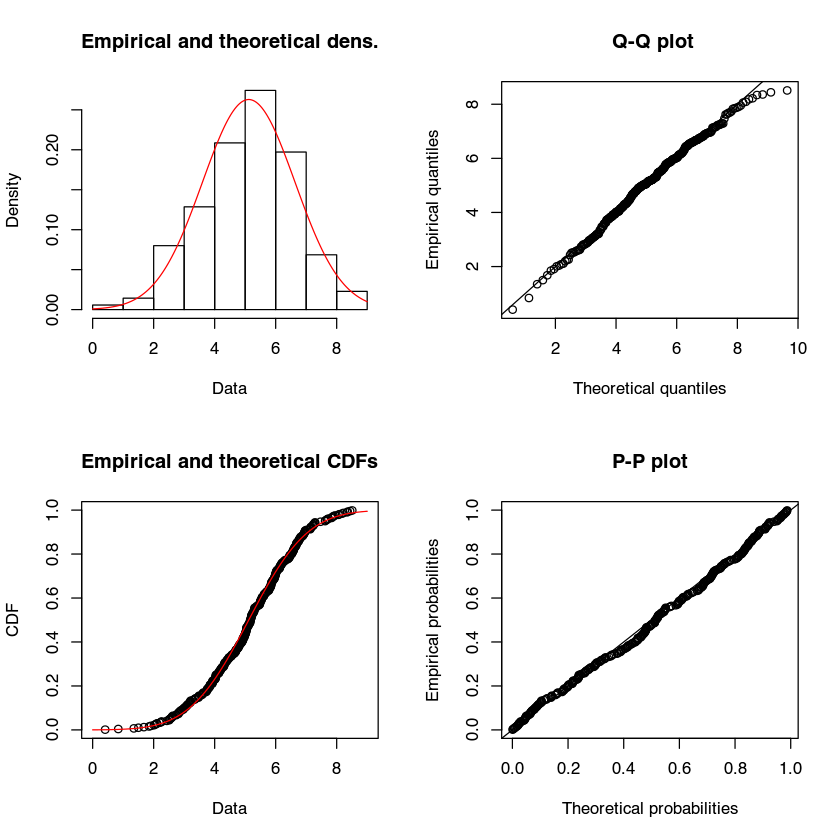

In [8]:
inst_1_model <- fitdist(
    subset(dataset,instrument=='instrument_1')$measurement,
    'norm',
    discrete=FALSE,
    )
summary(inst_1_model)
plot(inst_1_model)

### Instrument 1's data comes from a normal distribution with $\mu \approx 5.12$ and $\sigma \approx 1.52$

number of iterations= 86 
summary of normalmixEM object:
         comp 1   comp 2
lambda 0.564451 0.435549
mu     3.910994 5.782471
sigma  0.582752 0.546934
loglik at estimate:  -494.2502 


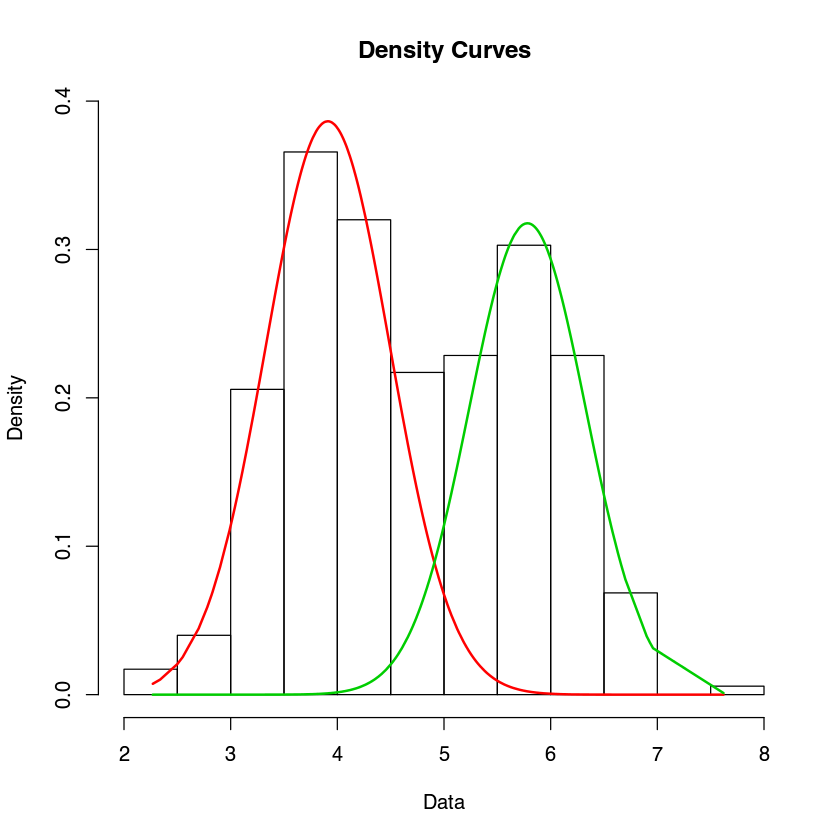

In [9]:
instr_2_model<-normalmixEM(subset(dataset,instrument=='instrument_2')$measurement,k=2,fast=FALSE)
plot(instr_2_model,whichplots=2)
summary(instr_2_model)

### Instrument 2's data comes from a mixture of 2 normal distributions with $(\mu_1, \sigma_1, \lambda_1)\approx(3.91,0.582,0.564)$, $(\mu_2, \sigma_2, \lambda_2)\approx(5.78,0.547,0.435)$, where $\lambda$ is mixing proportion.

Fitting of the distribution ' norm ' by maximum likelihood 
Parameters : 
     estimate Std. Error
mean 6.064657 0.05474164
sd   1.024122 0.03870802
Loglikelihood:  -504.9711   AIC:  1013.942   BIC:  1021.658 
Correlation matrix:
     mean sd
mean    1  0
sd      0  1


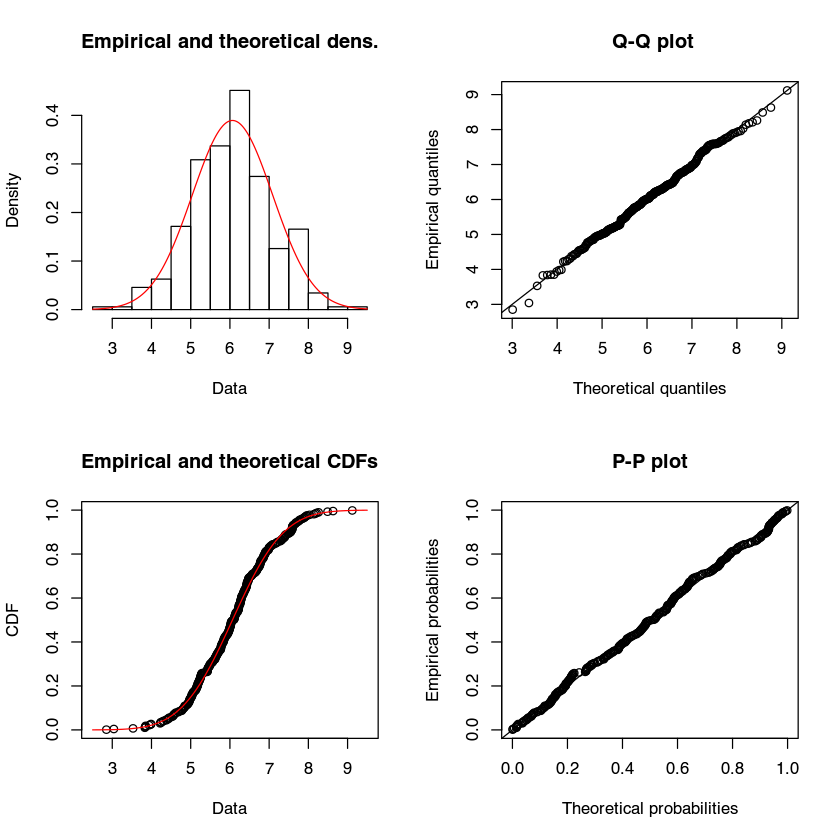

In [10]:
instr_3_model <- fitdist(
    subset(dataset,instrument=='instrument_3')$measurement,
    'norm',
    discrete=FALSE,
    )
summary(instr_3_model)
plot(instr_3_model)

### Instrument 3's data comes from a normal distribution with $\mu \approx 6.06$ and $\sigma \approx 1.02$ 

Fitting of the distribution ' norm ' by maximum likelihood 
Parameters : 
     estimate Std. Error
mean 5.056629 0.08588810
sd   1.606819 0.06073195
Loglikelihood:  -662.6183   AIC:  1329.237   BIC:  1336.952 
Correlation matrix:
     mean sd
mean    1  0
sd      0  1


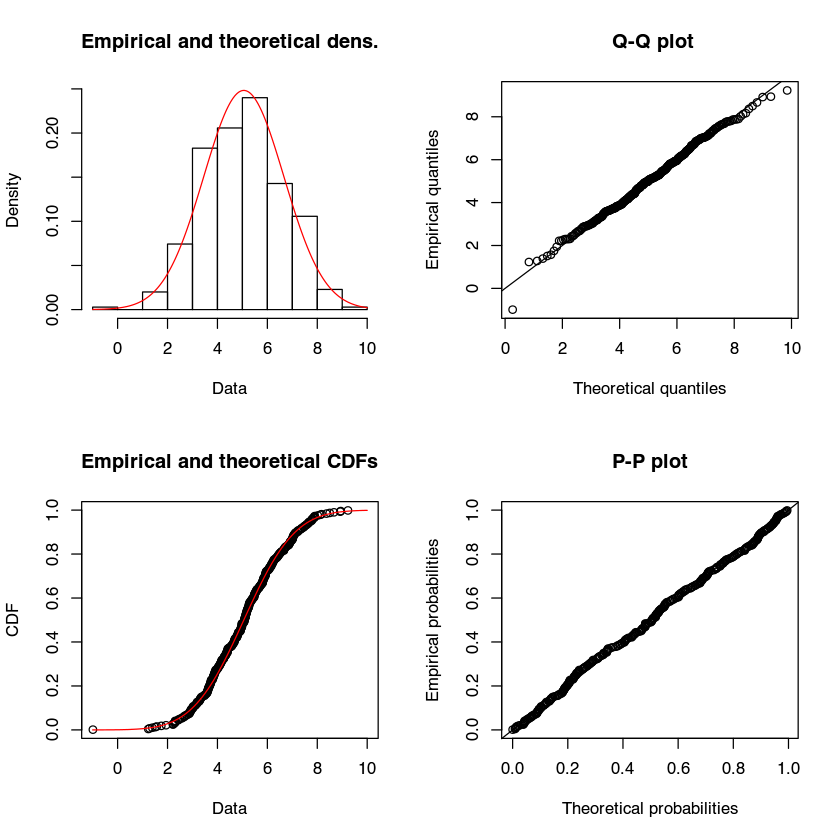

In [11]:
instr_4_model <- fitdist(
    subset(dataset,instrument=='instrument_4')$measurement,
    'norm',
    discrete=FALSE,
    )
summary(instr_4_model)
plot(instr_4_model)

### Instrument 4's data comes from a normal distribution with $\mu \approx 5.06$ and $\sigma \approx 0.0859$

number of iterations= 52 
summary of normalmixEM object:
         comp 1   comp 2
lambda 0.562130 0.437870
mu     3.990490 5.759435
sigma  0.599679 0.438931
loglik at estimate:  -469.9823 


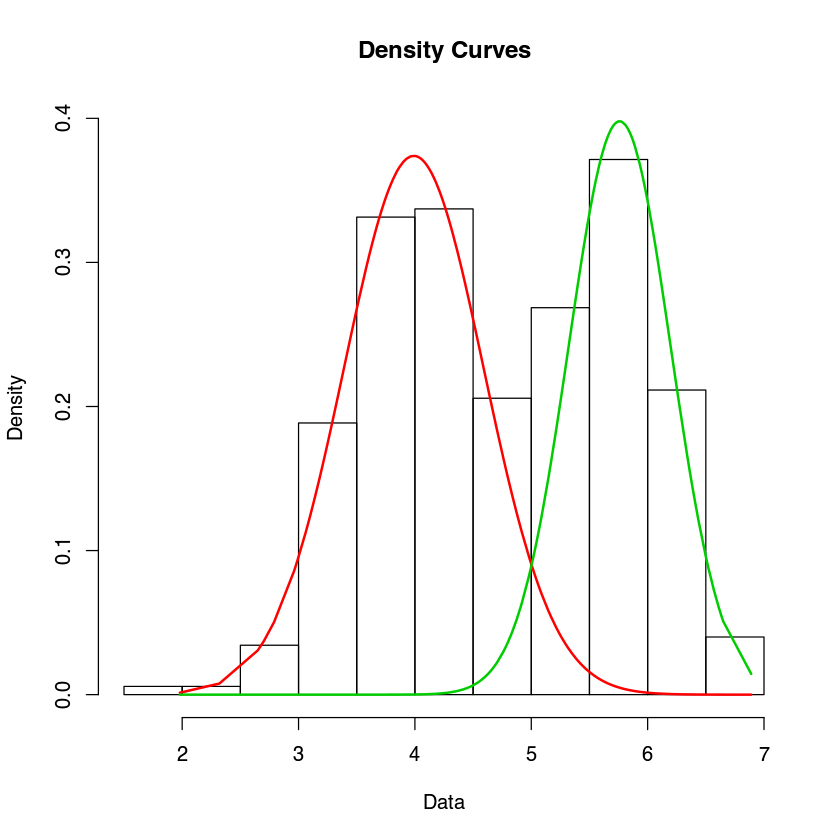

In [12]:
instr_5_model<-normalmixEM(subset(dataset,instrument=='instrument_5')$measurement,k=2,fast=FALSE)
plot(instr_5_model,whichplots=2)
summary(instr_5_model)

### Instrument 5's data comes from a mixture of 2 normal distributions with $(\mu_1, \sigma_1, \lambda_1)\approx(3.99,0.600,0.562)$, $(\mu_2, \sigma_2, \lambda_2)\approx(5.76,0.439,0.438)$, where $\lambda$ is mixing proportion.